In [1]:
# Imports
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
import xarray as xr
import metpy
from datetime import datetime
import datetime as dt
from metpy.units import units
import scipy.ndimage as ndimage
from metpy.plots import USCOUNTIES
import cartopy
from scipy.ndimage.filters import generic_filter as gf
from metpy.plots import USCOUNTIES
from metpy.plots import SkewT
import metpy.calc as mpcalc
from math import log, exp
import matplotlib.patches as mpatches
import matplotlib.lines as lines
import supplementary_tools as spt
import soundingmaps as smap
from siphon.simplewebservice.wyoming import WyomingUpperAir



In [2]:
%matplotlib notebook

In [3]:
ds = xr.open_dataset('http://nomads.ncep.noaa.gov:80/dods/gfs_0p25_1hr/gfs20210325/gfs_0p25_1hr_00z')

C:\Users\Jack\anaconda3\envs\jupyterdev\lib\site-packages\xarray\coding\times.py:113: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [4]:
print(ds)

<xarray.Dataset>
Dimensions:         (lat: 721, lev: 41, lon: 1440, time: 121)
Coordinates:
  * time            (time) datetime64[ns] 2021-03-25 ... 2021-03-30
  * lev             (lev) float64 1e+03 975.0 950.0 925.0 ... 0.04 0.02 0.01
  * lat             (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon             (lon) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Data variables: (12/215)
    absvprs         (time, lev, lat, lon) float32 ...
    no4lftxsfc      (time, lat, lon) float32 ...
    acpcpsfc        (time, lat, lon) float32 ...
    albdosfc        (time, lat, lon) float32 ...
    apcpsfc         (time, lat, lon) float32 ...
    capesfc         (time, lat, lon) float32 ...
    ...              ...
    vwshneg2pv      (time, lat, lon) float32 ...
    vwshtrop        (time, lat, lon) float32 ...
    watrsfc         (time, lat, lon) float32 ...
    weasdsfc        (time, lat, lon) float32 ...
    wiltsfc         (time, lat, lon) float32 ...
    var00

In [5]:
data = ds.metpy.assign_crs(grid_mapping_name='latitude_longitude')
data = data.isel(time=12)

#Rename variables to useful things
data = data.rename(spt.get_varlist('GFS'))

In [6]:
data = ds.metpy.assign_crs(grid_mapping_name='latitude_longitude')
data = data.isel(time=12)

#Rename variables to useful things
data = data.rename(spt.get_varlist('GFS'))

In [7]:
prs_temps = data['temperature'].isel(lev=slice(1,18,1))
prs_relh = data['rh'].isel(lev=slice(1,18,1))
sfc_pressure = data['spres']/100

In [9]:
#Get current time and pick proper model run and verification time accordingly
current_utc = datetime.utcnow()
print(current_utc)

curr_utc_yr = current_utc.year
curr_utc_mo = current_utc.month
curr_utc_dy = current_utc.day

def get_verif_time(current_utc):
    if current_utc.hour <1:
        prev_utc = current_utc-dt.timedelta(days=1)
        verif_yr = prev_utc.year
        verif_mo = prev_utc.month
        verif_dy = prev_utc.day
        verif_time = datetime(verif_yr,verif_mo,verif_dy,12)
    elif current_utc.hour<13:
        verif_time = datetime(curr_utc_yr,curr_utc_mo,curr_utc_dy,0)
    else:
        verif_time = datetime(curr_utc_yr,curr_utc_mo,curr_utc_dy,12)
    return verif_time

def model_init_time(current_utc):
    if current_utc.hour <5:
        prev_utc = current_utc-dt.timedelta(days=1)
        init_yr = prev_utc.year
        init_mo = prev_utc.month
        init_dy = prev_utc.day
        init_time = datetime(init_yr,init_mo,init_dy,12)
    elif current_utc.hour<17:
        init_yr = current_utc.year
        init_mo = current_utc.month
        init_dy = current_utc.day
        init_time = datetime(init_yr,init_mo,init_dy,0)
    else:
        init_time = datetime(curr_utc_yr,curr_utc_mo,curr_utc_dy,12)
    return init_time

def model_init_string(init_time):
    year = init_time.year
    if init_time.month <10:
        month = '0'+str(init_time.month)
    else:
        month = str(init_time.month)

    if init_time.day <10:
        day = '0'+str(init_time.day)
    else:
        day = str(init_time.day)

    if init_time.hour <10:
        hour = '0'+str(init_time.hour)
    else:
        hour = str(init_time.hour)
    minute = '00'

    mdate = str(year)+str(month)+str(day)+'_'+hour+minute
    return mdate

verification_time = get_verif_time(current_utc)
model_init_time = model_init_time(current_utc)
mdate = model_init_string(model_init_time)
print(verification_time)
print(model_init_time)
print(mdate)


2021-03-25 13:00:50.145834
2021-03-25 12:00:00
2021-03-25 00:00:00
20210325_0000


In [10]:
#Initialize some empty lists and select all RAOB stations of interest
coords = []
obs_t = []
obs_td = []
obs_p = []

ideal_ua_station_ids = ['JAN','SHV','LCH','LIX','LZK','BMX','FFC','TLH']#,'FWD','SHV','CRP','LIX','LZK','DNR','LBF','OAX']
ua_station_ids = []

#'BRO', ,'SGF'

In [11]:
#Now that we have the model and verification time, get the RAOB data
for i in range(len(ideal_ua_station_ids)):
    try:
        df = WyomingUpperAir.request_data(verification_time,ideal_ua_station_ids[i])
        lat = df['latitude'][0]
        lon = df['longitude'][0]
        p = df['pressure'].values * units.hPa
        t = df['temperature'].values * units.degC
        td = df['dewpoint'].values * units.degC
        obs_t.append(t)
        obs_td.append(td)
        obs_p.append(p)
        coord = (lat,lon)
        coords.append(coord)
        ua_station_ids.append(ideal_ua_station_ids[i])
    except:
        'Data Unavailable For '+ideal_ua_station_ids[i]

In [12]:
datavars = ['temperature','dewpoint','pressure']
observed_data = xr.DataArray([obs_t,obs_td,obs_p],dims={'var':datavars,'station':ua_station_ids},coords={'var':datavars,'station':ua_station_ids})
print(observed_data.station)

<xarray.DataArray 'station' (station: 6)>
array(['JAN', 'LCH', 'LIX', 'LZK', 'BMX', 'TLH'], dtype='<U3')
Coordinates:
  * station  (station) <U3 'JAN' 'LCH' 'LIX' 'LZK' 'BMX' 'TLH'


C:\Users\Jack\anaconda3\envs\jupyterdev\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [13]:
width = 0.15 #+0.055
height = 0.1 #3

skew_locs = {'JAN':(.287,.525,width,height),'SHV':(0.118,0.532,width,height),'LCH':(.147,0.421,width,height),'LIX':(0.291,0.431,width,height),
             'LZK':(0.181,0.639,width,height),'BMX':(0.435,0.555,width,height),'FFC':(0.54,0.565,width,height),'TLH':(0.54,0.435,width,height)}#,
             #'FWD':(.5051,.425,width,height),'SHV':(.6275,.412,width,height),'CRP':(.5,.248,width,height),'LIX':(.769,.3403,width,height),
             #'LZK':(.685,.5,width,height),'DNR':(.239,.6692,width,height),'LBF':(.385,.717,width,height),'OAX':(.538,.725,width,height)}

# ,'BRO':(.501,.182,.15,.1) ,'SGF':(.645,.5842,.15,.1)

In [14]:
dashed_red_line = lines.Line2D([], [], linestyle='solid', color='r', label='Observed Temperature')
dashed_purple_line = lines.Line2D([],[],linestyle='dashed',color='purple',label='0C Isotherm')
dashed_green_line = lines.Line2D([], [], linestyle='solid', color='mediumblue', label='Observed Dew Point')
dashed_lgreen_line = lines.Line2D([], [], linestyle='solid', color='cornflowerblue', label='Modeled Dew Point')
dashed_lred_line = lines.Line2D([], [], linestyle='solid', color='lightcoral', label='Modeled Temperature')

grey_line = lines.Line2D([], [], color='darkgray', label='MSLP (hPa)')
blue_line = lines.Line2D([], [], color='b',label='Wet Bulb')
pink_line = lines.Line2D([], [], color='fuchsia',label='Surface-Based Parcel Path')
teal_line = lines.Line2D([], [], linestyle='dashed',color='teal',label='HGZ')
green_dot = lines.Line2D([], [], marker='o', color='forestgreen',label='LCL')
black_dot = lines.Line2D([], [], marker='o', color='k',label='RAOB Site')


<IPython.core.display.Javascript object>


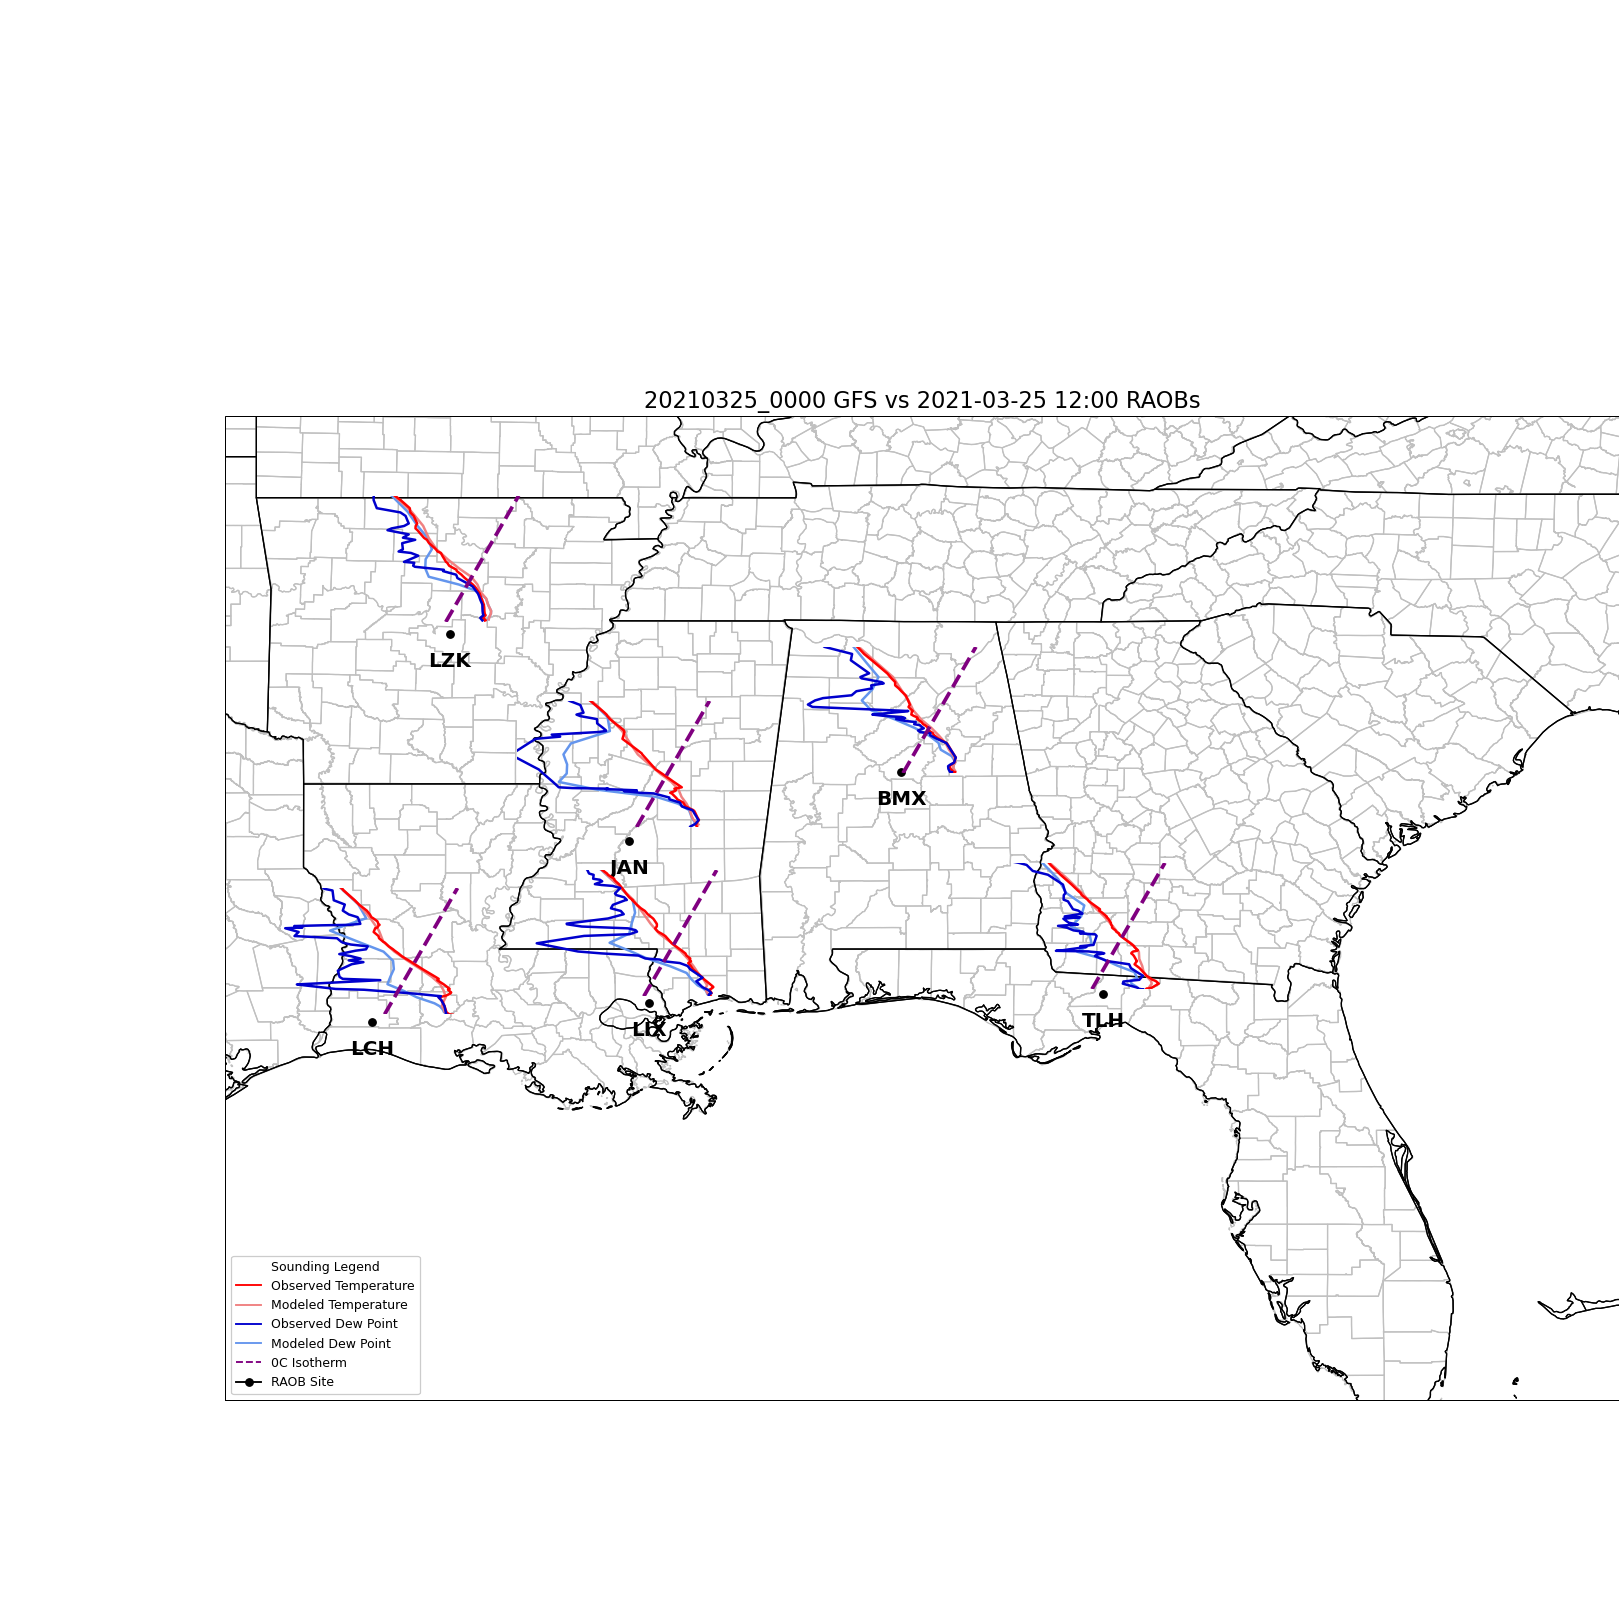

<xarray.DataArray 'spres' ()>
array(994.34182207)
Coordinates:
    time       datetime64[ns] 2021-03-25T12:00:00
    metpy_crs  object Projection: latitude_longitude
    lat        float64 32.32
    lon        float64 269.9
<xarray.DataArray 'spres' ()>
array(1004.55780664)
Coordinates:
    time       datetime64[ns] 2021-03-25T12:00:00
    metpy_crs  object Projection: latitude_longitude
    lat        float64 30.11
    lon        float64 266.8
<xarray.DataArray 'spres' ()>
array(1007.10281709)
Coordinates:
    time       datetime64[ns] 2021-03-25T12:00:00
    metpy_crs  object Projection: latitude_longitude
    lat        float64 30.34
    lon        float64 270.2
<xarray.DataArray 'spres' ()>
array(992.67148359)
Coordinates:
    time       datetime64[ns] 2021-03-25T12:00:00
    metpy_crs  object Projection: latitude_longitude
    lat        float64 34.84
    lon        float64 267.7
<xarray.DataArray 'spres' ()>
array(990.77646279)
Coordinates:
    time       datetime64[ns] 2021-03-2

In [15]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(111, projection = ccrs.PlateCarree())

ax1.add_feature(USCOUNTIES.with_scale('500k'), edgecolor='silver')
ax1.coastlines(resolution='10m')
ax1.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=1.5)
ax1.add_feature(cfeature.STATES.with_scale('10m'), linewidth=1.0)
ax1.set_extent((265,282,25.5,37.5))

for i in range(len(ua_station_ids)):
    station = ua_station_ids[i]
    lat = coords[i][0]
    lon = coords[i][1]
    
    station_obs_temp = observed_data.sel(var='temperature',station=station).values#.isel(station=1).values 
    station_obs_dewp = observed_data.sel(var='dewpoint',station=station).values#.isel(station=1).values 
    station_obs_pres = observed_data.sel(var='pressure',station=station).values#.isel(station=1).values 

    modeled_temps = prs_temps.interp(lat=lat,lon=360+lon)-273.15
    modeled_rh = prs_relh.interp(lat=lat,lon=360+lon)
    modeled_pres = prs_temps.lev
    spres = sfc_pressure.interp(lat=lat,lon=360+lon)
    print(spres)
    modeled_dp = mpcalc.dewpoint_from_relative_humidity(modeled_temps.data*units.degC,modeled_rh.data*units.percent)

    #Only want data above the ground
    abv_sfc_temp = spt.mask_below_terrain(spres,modeled_temps,modeled_pres)[0]
    abv_sfc_dewp = spt.mask_below_terrain(spres,modeled_dp,modeled_pres)[0]
    pres_abv_ground = spt.mask_below_terrain(spres,modeled_temps,modeled_pres)[1]
    
    skew_rect = skew_locs[station]

    skew = SkewT(fig=fig,rect=skew_rect)  

    skew.plot(pres_abv_ground,abv_sfc_dewp,'cornflowerblue',linewidth=2)
    skew.plot(pres_abv_ground,abv_sfc_temp,'lightcoral',linewidth=2)    

    skew.plot(station_obs_pres,station_obs_temp,'r',linewidth=2)
    skew.plot(station_obs_pres,station_obs_dewp,'mediumblue',linewidth=2)
   
    
    skew.ax.axvline(0, color='purple', linestyle='--', linewidth=3)
    skew.ax.set_ylim((1000,300))
    skew.ax.axis('off') 
    
    ax1.plot(360+lon,lat,color='k',marker='o',transform=ccrs.PlateCarree())
    ax1.text(360+coords[i][1],coords[i][0]-.4,ua_station_ids[i],ha='center',transform=ccrs.PlateCarree(),fontsize=16,fontweight='bold')

ax1.set_title(str(mdate)+' GFS vs '+str(verification_time)[0:16]+' RAOBs',fontsize=18)
#ax1.set_title('Valid: '+verification_time.strftime('%Y-%m-%d %H:%MZ'),fontsize=11,loc='right')
#ax1.set_title('GFS Init: '+model_init_time.strftime('%Y-%m-%d %H:%MZ').item(),fontsize=11,loc='left')

leg = ax1.legend(handles=[dashed_red_line,dashed_lred_line,dashed_green_line,dashed_lgreen_line,dashed_purple_line,black_dot],title='Sounding Legend',loc=3,framealpha=1)


plt.savefig('dixie_verif_skewmap_v7.png',bbox_inches='tight',pad_inches=0.1)
#plt.show()